# Titiler-CMR Compatibility and Performance Benchmarking

This notebook walks you through a practical workflow to **validate compatibility** and then **benchmark performance** of a [TiTiler-CMR](https://github.com/developmentseed/titiler-cmr) deployment for a given Earthdata CMR dataset.


> **What is TiTiler-CMR?**  
> [TiTiler](https://github.com/developmentseed/titiler) is a lightweight dynamic tiling server for raster/COG data. **TiTiler-CMR** is a variant/deployment that integrates with NASA's **Common Metadata Repository (CMR)** so you can render tiles **directly from CMR-managed datasets** (e.g., HDF5/NetCDF4/GRIB hosted on Earthdata Cloud). It can resolve a **CMR concept ID** to a renderable item, and expose tile and statistics endpoints without you needing to manually construct source URLs.

In this notebook, you'll learn:


In [20]:
import asyncio
import pandas as pd

# Import your library pieces (adjust path/imports if your package lives elsewhere)
from datacube_benchmark.titiler_cmr_benchmark import (
    DatasetParams,
    TiTilerCMRBenchmarker,
    benchmark_viewport,
    benchmark_tileset,
    benchmark_statistics,
    check_titiler_cmr_compatibility,
    create_bbox_feature,
    tiling_benchmark_summary
)

# Optional display tweaks
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", None)

## Setup

- Choose a Titiler-CMR endpoint
- Pick a collection
- Define a temporal interval (`start/end` ISO range) and, if needed, a time step (e.g., daily).
- Select a backend that matches your dataset’s structure

Titiler-CMR supports two different backends:
  - **xarray** → for gridded/cloud-native datasets (e.g., NetCDF4/HDF5/GRIB), typically exposed as variables.
  - **rasterio** → for COG/raster imagery-style datasets exposed as bands (optionally via a regex).

### Xarray Backend Example
Let’s start with a daily precipitation dataset using the xarray backend. We’ll use the DatasetParams.for_xarray() helper to configure this dataset for compatibility checks and performance benchmarking.


In [21]:
endpoint = "https://staging.openveda.cloud/api/titiler-cmr"

concept_id = "C2723754864-GES_DISC"
datetime_range="2022-03-01T00:00:01Z/2022-03-02T23:59:59Z"
variable="precipitation"

ds_xarray = DatasetParams.for_xarray(
    concept_id="C2723754864-GES_DISC",
    datetime_range="2022-03-01T00:00:01Z/2022-03-02T23:59:59Z",
    variable="precipitation",
    step="P1D",
    temporal_mode="point"
    )


Now, let's check if the configurations and dataset we chose are compatible with TiTiler-CMR.

This step verifies that:
- Resolve the dataset metadata and TileJSON
- Determine how many time steps are available within the requested interval
- Query the /statistics endpoint for a preview time range

The result is a summary of compatibility, tiling parameters, and dataset statistics.

In [22]:
compat = await check_titiler_cmr_compatibility(
    endpoint=endpoint,
    dataset=ds_xarray,
    timeout_s=250.0,
)

print(f"Compatibility: {compat['compatibility']}")
print(f"Timesteps: {compat['n_timesteps']}")
print(f"Bounds: {compat['tilejson_bounds']}")
if not compat['statistics'].empty:
    print(f"Statistics preview:\n{compat['statistics']}")

=== TiTiler-CMR Compatibility Check ===
Client: 2 physical / 4 logical cores | RAM: 30.89 GiB
Dataset: C2723754864-GES_DISC (xarray)
Query params: 6 parameters
  concept_id: C2723754864-GES_DISC
  backend: xarray
  datetime: 2022-03-01T00:00:01Z/2022-03-02T23:59:59Z
  variable: precipitation
  step: P1D
  temporal_mode: point
Found 2 timesteps/granules from TileJson!
Statistics request failed: RuntimeError: Cannot send a request, as the client has been closed.
Compatibility: issues_detected
Timesteps: 2
Bounds: [-180.0, -90.0, 180.0, 90.0]


Now, let's do the same test with variable `sst`:

In [23]:
ds_xarray = DatasetParams.for_xarray(
    concept_id="C2723754864-GES_DISC",
    datetime_range="2022-03-01T00:00:01Z/2022-03-02T23:59:59Z",
    variable="sst",
    step="P1D",
    temporal_mode="point"
    )

compat = await check_titiler_cmr_compatibility(
    endpoint=endpoint,
    dataset=ds_xarray,
    timeout_s=250.0,
)

print(f"Compatibility: {compat['compatibility']}")
print(f"Timesteps: {compat['n_timesteps']}")
print(f"Bounds: {compat['tilejson_bounds']}")
if not compat['statistics'].empty:
    print(f"Statistics preview:\n{compat['statistics']}")

=== TiTiler-CMR Compatibility Check ===
Client: 2 physical / 4 logical cores | RAM: 30.89 GiB
Dataset: C2723754864-GES_DISC (xarray)
Query params: 6 parameters
  concept_id: C2723754864-GES_DISC
  backend: xarray
  datetime: 2022-03-01T00:00:01Z/2022-03-02T23:59:59Z
  variable: sst
  step: P1D
  temporal_mode: point
Found 2 timesteps/granules from TileJson!
Statistics request failed: RuntimeError: Cannot send a request, as the client has been closed.
Compatibility: issues_detected
Timesteps: 2
Bounds: [-180.0, -90.0, 180.0, 90.0]


**Tip: Explore the granules with `earthaccess`**

You can use [`earthaccess`](https://github.com/nsidc/earthaccess) to search and inspect the individual granules used in your query. This helps you validate which files were accessed via TiTiler-CMR and optionally download or explore them further.

```python
import earthaccess

# Define your parameters
concept_id = "C2723754864-GES_DISC"
time_range = ("2022-03-01T00:00:01Z", "2022-03-02T23:59:59Z")

# Authenticate if needed
earthaccess.login(strategy="netrc")  # or use "interactive" if needed

# Search for granules using the same temporal range
results = earthaccess.search_data(
    concept_id=concept_id,
    temporal=time_range
)

print(f"Found {len(results)} granules between {time_range[0]} and {time_range[1]}")

for g in results:
    start = g["umm"]["TemporalExtent"]["RangeDateTime"]["BeginningDateTime"]
    size  = float(g["granule_size_mb"])  # or use g["size"] if using older version

    print(f"\n{start} → {size:.2f} MB")

    for link in g.data_links(access="direct"):
        print(" ", link)

You can also run a similar check on a subset of data that has been defined by `tiling.create_bbox_feature`

In [24]:
ds_xarray = DatasetParams.for_xarray(
    concept_id="C2723754864-GES_DISC",
    datetime_range="2022-03-01T00:00:01Z/2022-03-02T23:59:59Z",
    variable="precipitation",
    step="P1D",
    temporal_mode="point"
    )
small_area = create_bbox_feature(-95.0, 28.0, -94.0, 29.0)
compat = await check_titiler_cmr_compatibility(
    endpoint=endpoint,
    dataset=ds_xarray,
    geometry=small_area,
    timeout_s=120.0,
)
print(f"Compatibility: {compat['compatibility']}")
print(f"Timesteps: {compat['n_timesteps']}")
print(f"Bounds: {compat['tilejson_bounds']}")
if not compat['statistics'].empty:
    print(f"Statistics preview:\n{compat['statistics']}")

=== TiTiler-CMR Compatibility Check ===
Client: 2 physical / 4 logical cores | RAM: 30.89 GiB
Dataset: C2723754864-GES_DISC (xarray)
Query params: 6 parameters
  concept_id: C2723754864-GES_DISC
  backend: xarray
  datetime: 2022-03-01T00:00:01Z/2022-03-02T23:59:59Z
  variable: precipitation
  step: P1D
  temporal_mode: point
Found 2 timesteps/granules from TileJson!
Statistics request failed: RuntimeError: Cannot send a request, as the client has been closed.
Compatibility: issues_detected
Timesteps: 2
Bounds: [-180.0, -90.0, 180.0, 90.0]


### RasterIO backend

Now, let's try an example of testing compatibility using the `rasterio` backend.

In [25]:
# Dataset 2: Rasterio Backend (HLS)
ds_hls = DatasetParams.for_rasterio(
    concept_id="C2036881735-POCLOUD",
    datetime_range="2024-10-01T00:00:00Z/2024-10-10T23:59:59Z",
    bands=["B04", "B03", "B02"],
    bands_regex="B[0-9][0-9]",
    rescale="0,10000",

)

In [26]:
compat = await check_titiler_cmr_compatibility(
    endpoint=endpoint,
    dataset=ds_hls,
    timeout_s=120.0,
)
print(f"Compatibility: {compat['compatibility']}")
print(f"Timesteps: {compat['n_timesteps']}")
print(f"Bounds: {compat['tilejson_bounds']}")
if not compat['statistics'].empty:
    print(f"Statistics preview:\n{compat['statistics']}")

=== TiTiler-CMR Compatibility Check ===
Client: 2 physical / 4 logical cores | RAM: 30.89 GiB
Dataset: C2036881735-POCLOUD (rasterio)
Query params: 8 parameters
  concept_id: C2036881735-POCLOUD
  backend: rasterio
  datetime: 2024-10-01T00:00:00Z/2024-10-10T23:59:59Z
  bands: B04
  bands: B03
  bands: B02
  bands_regex: B[0-9][0-9]
  rescale: 0,10000


Found 11 timesteps/granules from TileJson!
Statistics request failed: RuntimeError: Cannot send a request, as the client has been closed.
Compatibility: issues_detected
Timesteps: 11
Bounds: [-180.0, -90.0, 180.0, 90.0]


## Tiling Benchmark Over a custom bounds region

In this part, we are going to measure response latency across the tiles at different zoom levels using `benchmark_titiler_cmr` function. 
This function simulates the load of a typical viewport render in a slippy map, where multiple adjacent tiles must be fetched in parallel to draw a single view.

Under the hood, `benchmark_titiler_cmr` computes the center tile for each zoom level, selects its neighboring tiles to approximate a viewport, and requests them concurrently from the TiTiler-CMR endpoint. This function returns a pandas DataFrame containing the response times for each tile request.

In [27]:
df_viewport = await benchmark_viewport(
    endpoint=endpoint,
    dataset=ds_xarray,
    lng=-95.0,
    lat=29.0,
    viewport_width=3,
    viewport_height=3,
    min_zoom=7,
    max_zoom=8,
    timeout_s=60.0,
)

df_viewport.head()



=== TiTiler-CMR Tile Benchmark ===
Client: 2 physical / 4 logical cores | RAM: 30.89 GiB
Dataset: C2723754864-GES_DISC (xarray)
Query params: 8 parameters
  concept_id: C2723754864-GES_DISC
  backend: xarray
  datetime: 2022-03-01T00:00:01Z/2022-03-02T23:59:59Z
  variable: precipitation
  step: P1D
  temporal_mode: point
  tile_format: png
  tile_scale: 1
Found 2 timesteps from TileJson.
Zoom 7: 3x3 tiles (9 total)
Zoom 8: 3x3 tiles (9 total)


,z,x,y,timestep_index,url,response,status_code,elapsed_s,size_bytes,content_type,ok,no_data,error_text,rss_delta
0,7,29,52,0,https://staging.openveda.cloud/api/titiler-cmr...,<Response [200 OK]>,200,1.071505,694,image/png,True,False,None,270336
1,7,29,52,1,https://staging.openveda.cloud/api/titiler-cmr...,<Response [200 OK]>,200,0.887765,694,image/png,True,False,None,0
2,7,30,52,0,https://staging.openveda.cloud/api/titiler-cmr...,<Response [200 OK]>,200,0.771767,694,image/png,True,False,None,270336
3,7,30,52,1,https://staging.openveda.cloud/api/titiler-cmr...,<Response [200 OK]>,200,0.724302,694,image/png,True,False,None,0
4,7,31,52,0,https://staging.openveda.cloud/api/titiler-cmr...,<Response [200 OK]>,200,0.790623,694,image/png,True,False,None,270336


**Columns**
- `zoom, x, y` — XYZ tile indices
- `status_code` — HTTP code (200 = success, 204 = no-data, 4xx/5xx = errors)
- `response_time_sec` — wall time in seconds
- `response_size_bytes` — payload size
- `is_error, has_data` — convenience flags




In [28]:
print(f"Viewport results: {len(df_viewport)} tile requests")
df_summary= tiling_benchmark_summary(df_viewport)
df_summary

Viewport results: 36 tile requests


,z,timestep_index,n_tiles,ok_pct,no_data_pct,error_pct,median_latency_s,p95_latency_s,median_size,median_rss_delta
0,7,0,9.0,100.0,0.0,0.0,0.762773,0.959152,694.0,270336.0
1,7,1,9.0,100.0,0.0,0.0,0.724302,1.005209,694.0,0.0
2,8,0,9.0,100.0,0.0,0.0,0.789636,0.934960,694.0,270336.0
3,8,1,9.0,100.0,0.0,0.0,0.768384,1.089534,694.0,0.0


### Statistics Endpoint Benchmarking

This section benchmarks the `/statistics` endpoint of the TiTiler-CMR service. The statistics endpoint provides summary statistics (e.g., min, max, mean) for a specified variable over a given spatial and temporal extent. 



In [29]:
gulf_geometry = create_bbox_feature(-98.676, 18.857, -81.623, 31.097)
stats_result = await benchmark_statistics(
    endpoint=endpoint,
    dataset=ds_xarray,
    geometry=gulf_geometry,
    timeout_s=300.0,
)
print("Statistics result:")
print(f"  Success: {stats_result['success']}")
print(f"  Elapsed: {stats_result['elapsed_s']:.2f}s")
print(f"  Timesteps: {stats_result['n_timesteps']}")
print(f"  Statistics: {stats_result['statistics']}")


=== TiTiler-CMR Statistics Benchmark ===
Client: 2 physical / 4 logical cores | RAM: 30.89 GiB
Dataset: C2723754864-GES_DISC (xarray)
Statistics result:
  Success: True
  Elapsed: 1.42s
  Timesteps: 2
  Statistics: {'2022-03-01T00:00:01+00:00': {'2022-03-01T00:00:00.000000000': {'min': 0.0, 'max': 42.82999801635742, 'mean': 0.3393020033836365, 'count': 20898.5, 'sum': 7090.90283203125, 'std': 1.9955874881629714, 'median': 0.0, 'majority': 0.0, 'minority': 0.044999994337558746, 'unique': 1347.0, 'histogram': [[20614, 232, 65, 46, 20, 19, 14, 16, 4, 3], [0.0, 4.2829999923706055, 8.565999984741211, 12.848999977111816, 17.131999969482422, 21.415000915527344, 25.697999954223633, 29.980998992919922, 34.263999938964844, 38.547000885009766, 42.82999801635742]], 'valid_percent': 100.0, 'masked_pixels': 0.0, 'valid_pixels': 21033.0, 'percentile_2': 0.0, 'percentile_98': 4.244999885559082}}, '2022-03-02T00:00:01+00:00': {'2022-03-02T00:00:00.000000000': {'min': 0.0, 'max': 18.755001068115234, 'me

Now, let's create a simple function to summarize and plot latency vs. zoom level plot: 

In [ ]:

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D

async def summarize_and_plot_tiles(
    ds,
    *,
    endpoint: str,
    min_zoom: int,
    max_zoom: int,
    lng: float,
    lat: float,
    tile_format: str,
    timeout_s: float = 30.0,
    jitter: float = 0.08,
    alpha: float = 0.35,
):
    """
    Run a viewport tile benchmark, summarize it, and plot latency vs zoom.

    Returns
    -------
    summary : pd.DataFrame
        Aggregated metrics by zoom/timestep (from `tiling_benchmark_summary`).
    (fig, ax) : tuple
        Matplotlib figure and axes for the latency scatter/median plot.
    """
    async def run_tile_benchmark():
        df = await benchmark_viewport(
            endpoint=endpoint,
            dataset=ds,
            min_zoom=min_zoom,
            max_zoom=max_zoom,
            lng=lng,
            lat=lat,
            tile_format=tile_format,
            timeout_s=timeout_s,
        )
        return df

    df = await run_tile_benchmark()
    if df.empty:
        raise ValueError("Empty DataFrame: no results to summarize/plot.")

    # --- normalize column names used downstream ---
    rename_map = {}
    if "z" in df.columns and "zoom" not in df.columns:
        rename_map["z"] = "zoom"
    if "elapsed_s" in df.columns and "response_time_sec" not in df.columns:
        rename_map["elapsed_s"] = "response_time_sec"
    df = df.rename(columns=rename_map)

    # sanity: ensure expected columns exist
    for col in ["zoom", "response_time_sec", "ok", "no_data"]:
        if col not in df.columns:
            raise KeyError(f"Expected column '{col}' not found after normalization.")

    # build summary (tiling_benchmark_summary expects 'z' and 'no_data')
    summary = tiling_benchmark_summary(
        df.rename(columns={"zoom": "z"})
    ).copy()

    # --- plotting ---
    fig, ax = plt.subplots(figsize=(9, 5))
    fig.subplots_adjust(right=0.72, top=0.78)

    zoom_levels = sorted(int(z) for z in pd.to_numeric(df["zoom"], errors="coerce").dropna().unique())
    ax.set_xticks(zoom_levels)
    if zoom_levels:
        ax.set_xlim(min(zoom_levels) - 0.6, max(zoom_levels) + 0.6)

    for z in zoom_levels:
        sub = df[df["zoom"] == z]
        if sub.empty:
            continue

        x = np.random.normal(loc=z, scale=jitter, size=len(sub))  # jitter for visibility
        ok_mask = sub["ok"].astype(bool).values
        no_data_mask = sub["no_data"].astype(bool).values
        error_mask = ~(ok_mask | no_data_mask)

        ax.scatter(
            x[ok_mask],
            sub.loc[ok_mask, "response_time_sec"],
            alpha=alpha,
            edgecolor="none",
            label=None,
        )
        ax.scatter(
            x[error_mask],
            sub.loc[error_mask, "response_time_sec"],
            marker="x",
            alpha=min(0.8, alpha + 0.25),
            label=None,
        )

        med = sub["response_time_sec"].median()
        ax.hlines(med, z - 0.45, z + 0.45, linestyles="--")

    ax.set_xlabel("Zoom level")
    ax.set_ylabel("Tile response time (s)")

    success_proxy = Line2D([], [], linestyle="none", marker="o", label="200 OK")
    error_proxy   = Line2D([], [], linestyle="none", marker="x", label="error (not ok & not no_data)")
    ax.legend(
        [success_proxy, error_proxy],
        ["200 OK", "error"],
        frameon=False,
        loc="upper left",
        bbox_to_anchor=(1.02, 1.00),
        borderaxespad=0.0,
    )

    # dataset info block in title (robust to missing attrs)
    concept_id = getattr(ds, "concept_id", "—")
    dt_start = getattr(ds, "datetime_start", None)
    dt_end = getattr(ds, "datetime_end", None)
    try:
        dt_str = f"{dt_start.date()} \u2192 {dt_end.date()}" if dt_start and dt_end else "—"
    except Exception:
        dt_str = "—"
    assets = getattr(ds, "assets", None)
    assets_str = ", ".join(assets) if assets else "—"
    resampling = getattr(ds, "resampling", "—")

    info_lines = [
        f"concept_id: {concept_id}",
        f"format: {tile_format}",
        f"endpoint: {endpoint}",
    ]
    ax.set_title("\n".join(info_lines), fontsize=9, loc="left", pad=12)

    ax.grid(True, axis="y", alpha=0.2)
    plt.tight_layout()
    return summary, (fig, ax)

=== TiTiler-CMR Tile Benchmark ===
Client: 2 physical / 4 logical cores | RAM: 30.89 GiB
Dataset: C2723754864-GES_DISC (xarray)
Query params: 8 parameters
  concept_id: C2723754864-GES_DISC
  backend: xarray
  datetime: 2022-03-01T00:00:01Z/2022-03-20T23:59:59Z
  variable: precipitation
  step: P1D
  temporal_mode: point
  tile_format: png
  tile_scale: 1
Found 20 timesteps from TileJson.
Zoom 8: 5x5 tiles (25 total)
Zoom 9: 5x5 tiles (25 total)
Zoom 10: 5x5 tiles (25 total)


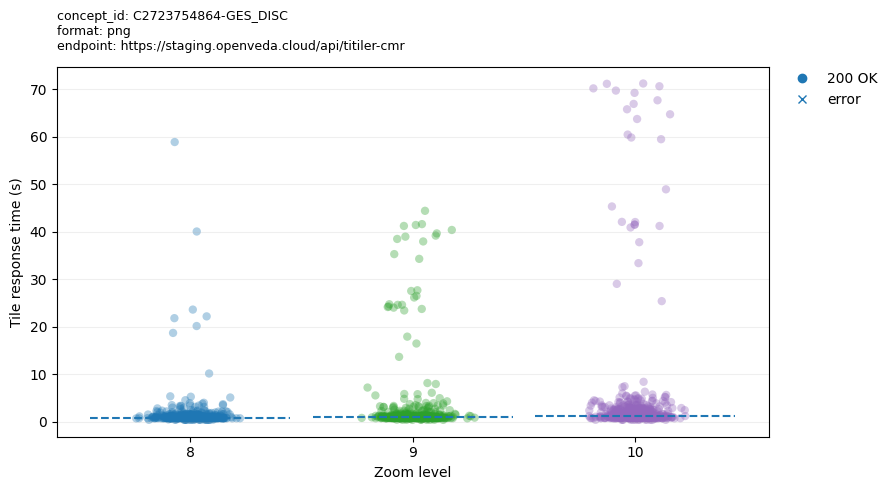

In [37]:
min_zoom=8
max_zoom=10
lng=-95.0
lat=29.0
tile_format="png"
timeout_s=120.0

summary, (fig, ax) = await summarize_and_plot_tiles(
    ds=ds_xarray,
    endpoint=endpoint,
    min_zoom=min_zoom,
    max_zoom=max_zoom,
    lng=lng,
    lat=lat,
    tile_format=tile_format,
    timeout_s=timeout_s,
)
plt.show()

Now, let's try to create similar plots for longer datetime range: 

=== TiTiler-CMR Tile Benchmark ===
Client: 2 physical / 4 logical cores | RAM: 30.89 GiB
Dataset: C2723754864-GES_DISC (xarray)
Query params: 8 parameters
  concept_id: C2723754864-GES_DISC
  backend: xarray
  datetime: 2022-03-01T00:00:01Z/2022-03-20T23:59:59Z
  variable: precipitation
  step: P1D
  temporal_mode: point
  tile_format: png
  tile_scale: 1
Found 20 timesteps from TileJson.
Zoom 8: 5x5 tiles (25 total)
Zoom 9: 5x5 tiles (25 total)
Zoom 10: 5x5 tiles (25 total)


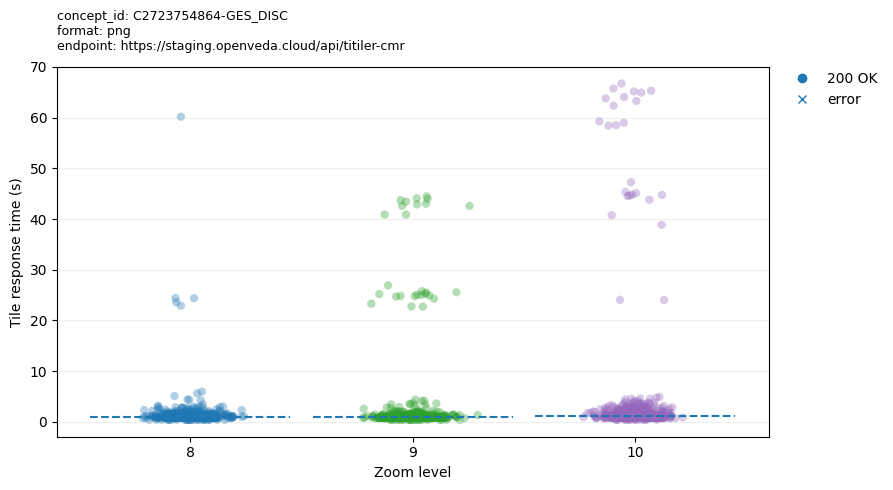

In [41]:
ds_xarray = DatasetParams.for_xarray(
    concept_id="C2723754864-GES_DISC",
    datetime_range="2022-03-01T00:00:01Z/2022-03-20T23:59:59Z",
    variable="precipitation",
    step="P1D",
    temporal_mode="point"
    )

min_zoom=8
max_zoom=10
lng=-95.0
lat=29.0
tile_format="png"
timeout_s=120.0

summary, (fig, ax) = await summarize_and_plot_tiles(
    ds=ds_xarray,
    endpoint=endpoint,
    min_zoom=min_zoom,
    max_zoom=max_zoom,
    lng=lng,
    lat=lat,
    tile_format=tile_format,
    timeout_s=timeout_s,
)
plt.show()

## Rasterio backend

In [ ]:
min_zoom = 4
max_zoom = 15
zoom_levels = list(range(min_zoom, max_zoom + 1))

ds_hls = DatasetParams.for_rasterio(
    concept_id="C2021957295-LPCLOUD",
    datetime_range="2024-10-01T00:00:01Z/2024-10-10T00:00:01Z",
    bands=[ "B02","B03","B09"],        # RGB bands
    bands_regex="B[0-9][0-9]",
    step="P1W",
    temporal_mode="point",
    rescale="0,10000",
)

df_viewport = await benchmark_viewport(
                endpoint=endpoint,
                dataset=ds_hls,
                lng=-95.0,
                lat=29.0,
                viewport_width=3,
                viewport_height=3,
                min_zoom=7,
                max_zoom=8,
                timeout_s=60.0,
            )
print(f"Viewport results: {len(df_viewport)} tile requests")
tiling_benchmark_summary(df_viewport)

=== TiTiler-CMR Tile Benchmark ===
Client: 2 physical / 4 logical cores | RAM: 30.89 GiB
Dataset: C2021957295-LPCLOUD (rasterio)
Query params: 12 parameters
  concept_id: C2021957295-LPCLOUD
  backend: rasterio
  datetime: 2024-10-01T00:00:01Z/2024-10-10T00:00:01Z
  bands: B02
  bands: B03
  bands: B09
  bands_regex: B[0-9][0-9]
  step: P1W
  temporal_mode: point
  rescale: 0,10000
  tile_scale: 1
  tile_format: png
Found 2 timesteps from TileJson.
Zoom 7: 3x3 tiles (9 total)
Zoom 8: 3x3 tiles (9 total)
Viewport results: 36 tile requests


,z,timestep_index,n_tiles,ok_pct,no_data_pct,error_pct,median_latency_s,p95_latency_s,median_size,median_rss_delta
0,7,0,9.0,0.0,100.0,0.0,3.281719,5.686533,0.0,0.0
1,7,1,9.0,0.0,100.0,0.0,3.012945,5.603497,0.0,0.0
2,8,0,9.0,0.0,100.0,0.0,3.879531,6.353494,0.0,0.0
3,8,1,9.0,0.0,100.0,0.0,2.967400,4.367048,0.0,0.0


=== TiTiler-CMR Tile Benchmark ===
Client: 2 physical / 4 logical cores | RAM: 30.89 GiB
Dataset: C2021957295-LPCLOUD (rasterio)
Query params: 11 parameters
  concept_id: C2021957295-LPCLOUD
  backend: rasterio
  datetime: 2024-10-01T00:00:01Z/2024-10-10T00:00:01Z
  bands: B02
  bands: B03
  bands: B09
  bands_regex: B[0-9][0-9]
  step: P1W
  temporal_mode: point
  tile_format: png
  tile_scale: 1
Found 2 timesteps from TileJson.
Zoom 8: 5x5 tiles (25 total)
Zoom 9: 5x5 tiles (25 total)
Zoom 10: 5x5 tiles (25 total)
Zoom 11: 5x5 tiles (25 total)
Zoom 12: 5x5 tiles (25 total)


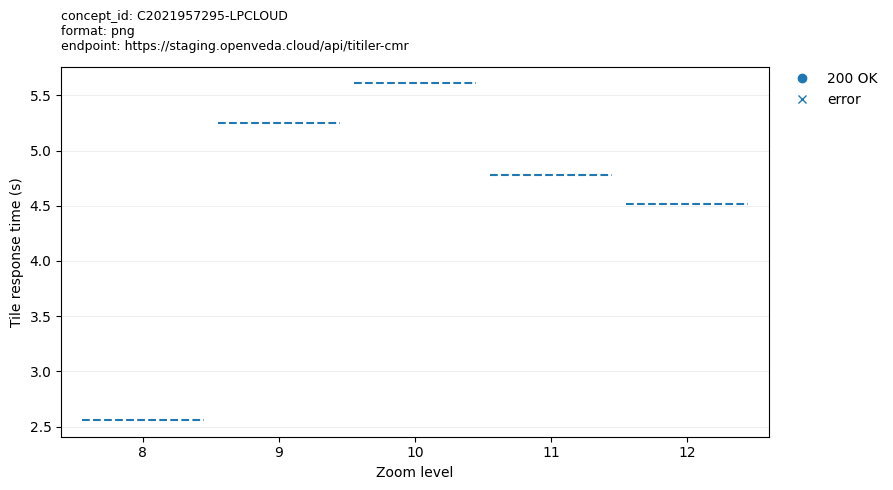

In [47]:
min_zoom=8
max_zoom=12
lng=-95.0
lat=29.0
tile_format="png"
timeout_s=120.0

summary, (fig, ax) = await summarize_and_plot_tiles(
    ds=ds_hls,
    endpoint=endpoint,
    min_zoom=min_zoom,
    max_zoom=max_zoom,
    lng=lng,
    lat=lat,
    tile_format=tile_format,
    timeout_s=timeout_s,
)
plt.show()


In [53]:
min_zoom = 5
max_zoom = 15
zoom_levels = list(range(min_zoom, max_zoom + 1))

start = "2023-01-01T00:00:00Z"
end   = "2023-01-07T23:59:59Z"

asset_sets = {
    "1 band": ["B04"],
    "2 bands": ["B04", "B03"],
    "3 bands": ["B04", "B03", "B02"],
}

tasks = []
labels = []

for label, assets in asset_sets.items():
    ds = DatasetParams.for_rasterio(
        concept_id=concept_id,
        datetime_range=f"{start}/{end}",
        bands=assets,
        # include other shared query args as needed:
        bands_regex="B[0-9][0-9]",
        step="P1W",
        temporal_mode="point",
    )
    tasks.append(
        benchmark_viewport(
            endpoint=endpoint,
            dataset=ds,
            lng=lng,
            lat=lat,
            min_zoom=min_zoom,
            max_zoom=max_zoom,
            tile_format=tile_format,
            timeout_s=timeout_s,
        )
    )
    labels.append(label)

dfs = await asyncio.gather(*tasks)

median_by_zoom = []
for df in dfs:
    # benchmark_viewport returns columns 'z' and 'elapsed_s'
    s = (
        df.groupby("z")["elapsed_s"]
          .median()
          .reindex(zoom_levels)
    )
    median_by_zoom.append(s)

panel_df = pd.concat(median_by_zoom, axis=1)
panel_df.columns = labels
panel_df

=== TiTiler-CMR Tile Benchmark ===
Client: 2 physical / 4 logical cores | RAM: 30.89 GiB
Dataset: C2723754864-GES_DISC (rasterio)
Query params: 9 parameters
  concept_id: C2723754864-GES_DISC
  backend: rasterio
  datetime: 2023-01-01T00:00:00Z/2023-01-07T23:59:59Z
  bands: B04
  bands_regex: B[0-9][0-9]
  step: P1W
  temporal_mode: point
  tile_format: png
  tile_scale: 1
=== TiTiler-CMR Tile Benchmark ===
Client: 2 physical / 4 logical cores | RAM: 30.89 GiB
Dataset: C2723754864-GES_DISC (rasterio)
Query params: 10 parameters
  concept_id: C2723754864-GES_DISC
  backend: rasterio
  datetime: 2023-01-01T00:00:00Z/2023-01-07T23:59:59Z
  bands: B04
  bands: B03
  bands_regex: B[0-9][0-9]
  step: P1W
  temporal_mode: point
  tile_format: png
  tile_scale: 1
=== TiTiler-CMR Tile Benchmark ===
Client: 2 physical / 4 logical cores | RAM: 30.89 GiB
Dataset: C2723754864-GES_DISC (rasterio)
Query params: 11 parameters
  concept_id: C2723754864-GES_DISC
  backend: rasterio
  datetime: 2023-01-0

,1 band,2 bands,3 bands
z,,,
5,2.885992,2.656239,2.463521
6,6.018334,6.316603,6.049553
7,6.334789,6.592872,7.313385
8,7.130915,6.107314,7.432439
9,6.758598,6.986528,7.530533
10,6.161228,8.099185,8.133895
11,6.530518,7.555630,8.625042
12,9.324527,8.527172,7.768077
13,8.558419,9.303800,7.643326


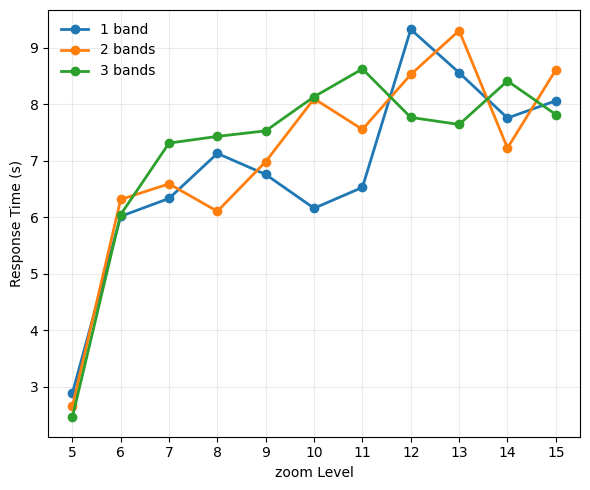

In [54]:
# --- plot all three lines together ---
fig, ax = plt.subplots(figsize=(6, 5))
for col in panel_df.columns:
    ax.plot(zoom_levels, panel_df[col].values, marker="o", linewidth=2, label=col)

ax.set_xticks(zoom_levels)             # exact zoom values
ax.set_xlabel("zoom Level")
ax.set_ylabel("Response Time (s)")
ax.grid(True, alpha=0.25)

# legend outside on the right
fig.subplots_adjust(right=0.78)
ax.legend(frameon=False, loc="best")

# optional title (set your collection name if you like)

plt.tight_layout()
plt.show()


## Result Summaries & Plots

Interpretation tips:
- Prefer **single-day** (or narrow) intervals for responsive rendering
- The bigger the time range, the more data needs to be scanned and processed
- Avoid very low zooms for heavy composites; consider **minzoom ≥ 7**